## Where's Wilma?

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

In [2]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [3]:
def calc_f2(x):
    x = x[None,0]
    vx = Variable(x.cuda(), requires_grad=True)
    sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]
    py = m(Variable(x.cuda()))
    for o in sfs: o.remove()
    py = np.exp(to_np(py)[0])
    feat = np.maximum(0,to_np(sfs[3].features[0]))
    f2=np.dot(np.rollaxis(feat,0,3), py)
    f2-=f2.min()
    f2/=f2.max()
    return f2

In [4]:
def show_raw(x, fig, pos):
    fig.add_subplot(2, 2, pos)
    dx = data.val_ds.denorm(x)[0]
    plt.imshow(dx)
    
def show_raws(x1, x2, x3, x4):
    fig=plt.figure(figsize=(12, 12))
    show_raw(x1, fig, 1)
    show_raw(x2, fig, 2)
    show_raw(x3, fig, 3)
    show_raw(x4, fig, 4)
    plt.show()
    
def hotspot(x, fig, pos):
    fig.add_subplot(2, 2, pos)
    f2 = calc_f2(x)
    dx = data.val_ds.denorm(x)[0]
    plt.imshow(dx)
    plt.imshow(resize(f2, dx.shape), alpha=0.5, cmap='hot')
    
def hotspots(x1, x2, x3, x4):
    fig=plt.figure(figsize=(12, 12))
    hotspot(x1, fig, 1)
    hotspot(x2, fig, 2)
    hotspot(x3, fig, 3)
    hotspot(x4, fig, 4)
    plt.show()

In [5]:
#PATH = "/home/ubuntu/data/dogscats/"
PATH = "/home/ubuntu/data/flintstones/"
sz = 224
arch = resnet34
bs = 64

In [6]:
m = arch(True)

In [7]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [8]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [9]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
hotspot_data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=1)
iterator = iter(hotspot_data.val_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


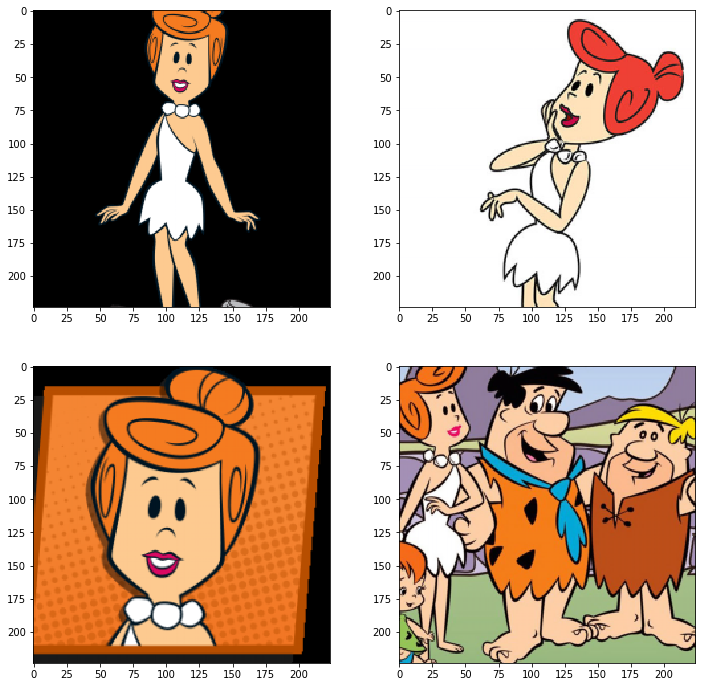

In [10]:
x1,y = next(iterator)
x2,y = next(iterator)
x3,y = next(iterator)
x4,y = next(iterator)

show_raws(x1, x2, x3, x4)

In [11]:
learn = ConvLearner.from_model_data(m, data)

In [12]:
learn.unfreeze()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      3.263405   2.608764   0.765625  



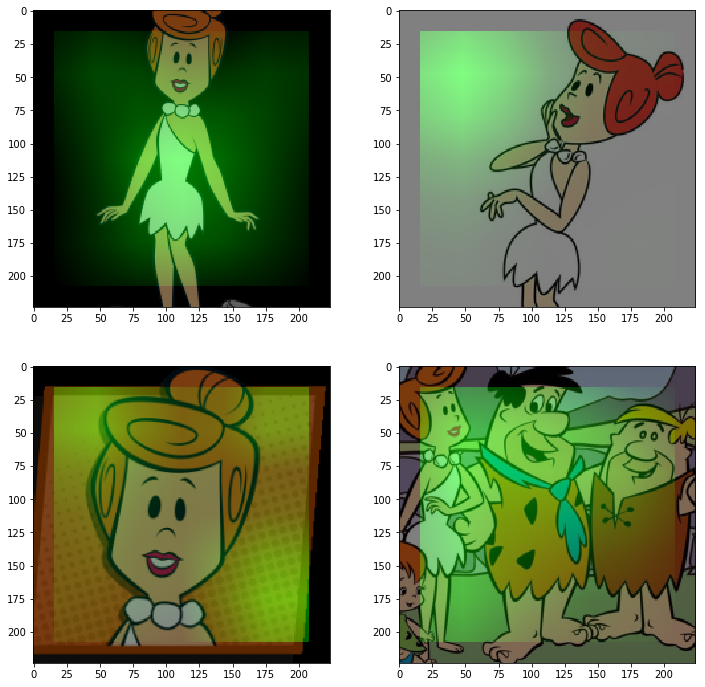

In [13]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.523063   1.282795   0.953125  



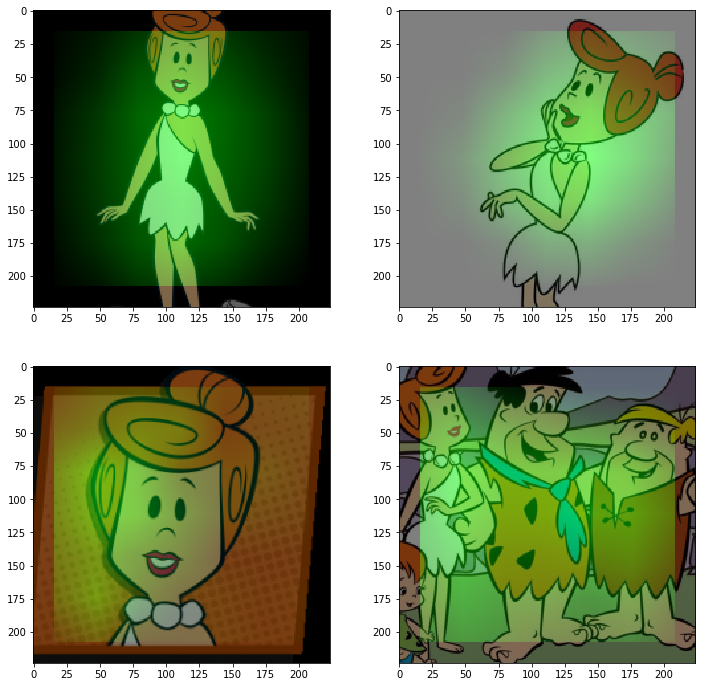

In [14]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.147822   0.834221   0.953125  



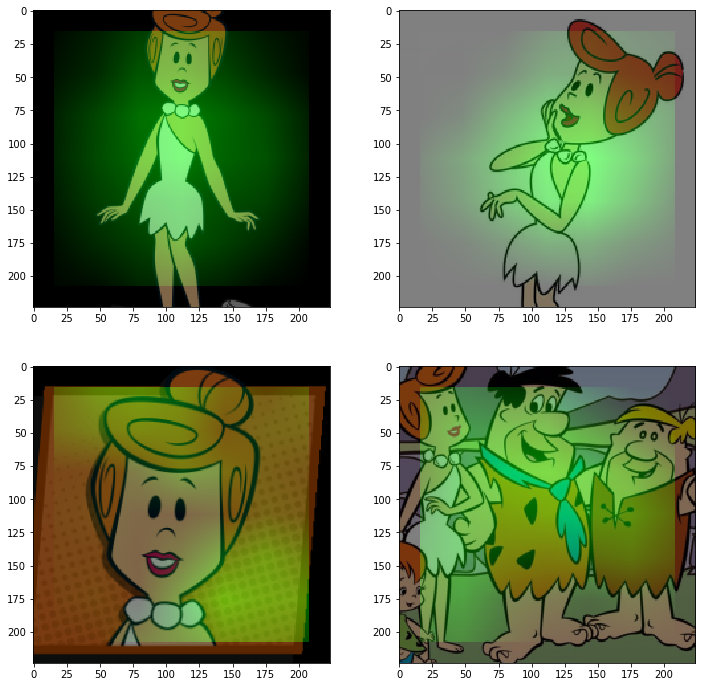

In [15]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.042305   0.489131   0.911458  



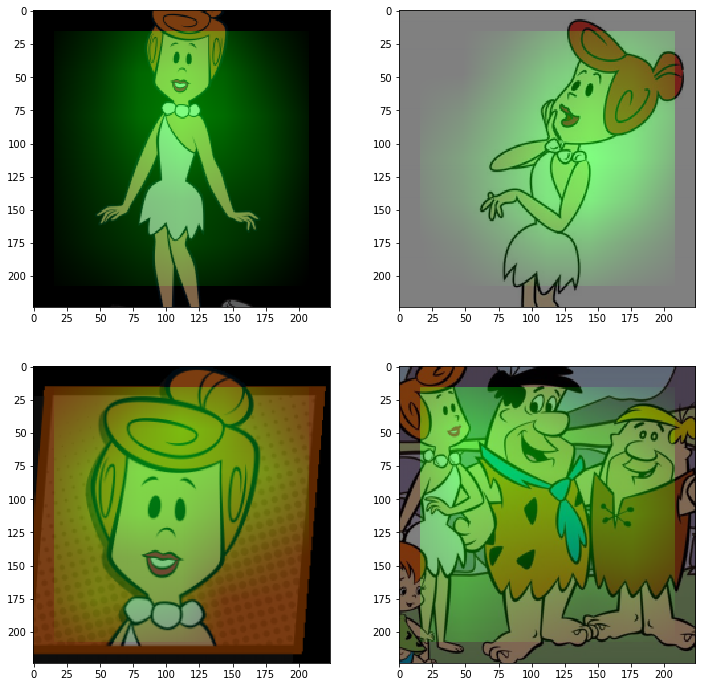

In [16]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.033484   0.471525   0.953125  



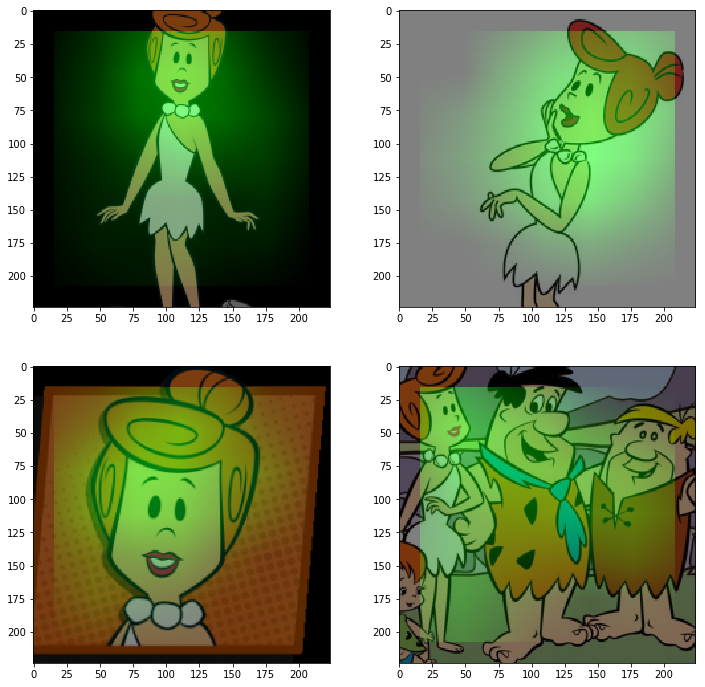

In [17]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.047283   0.701489   0.945312  



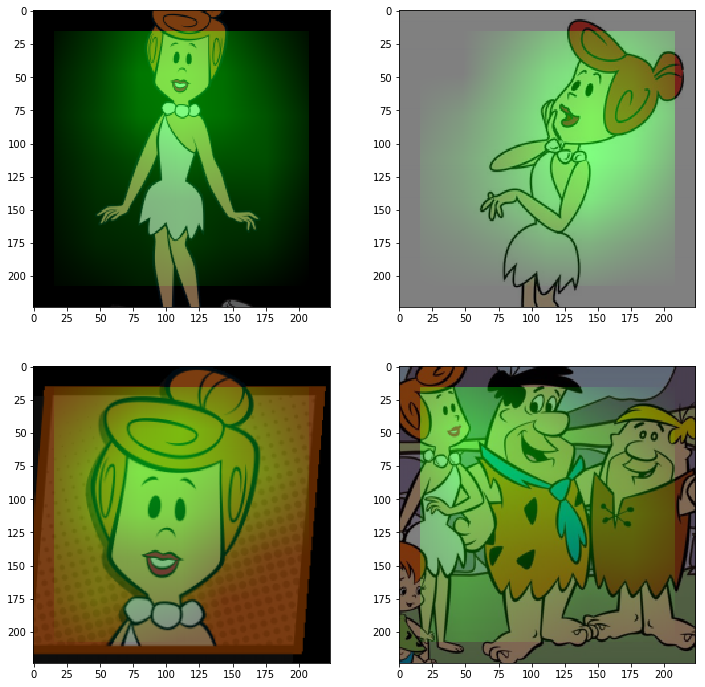

In [18]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.027263   0.276886   0.903646  



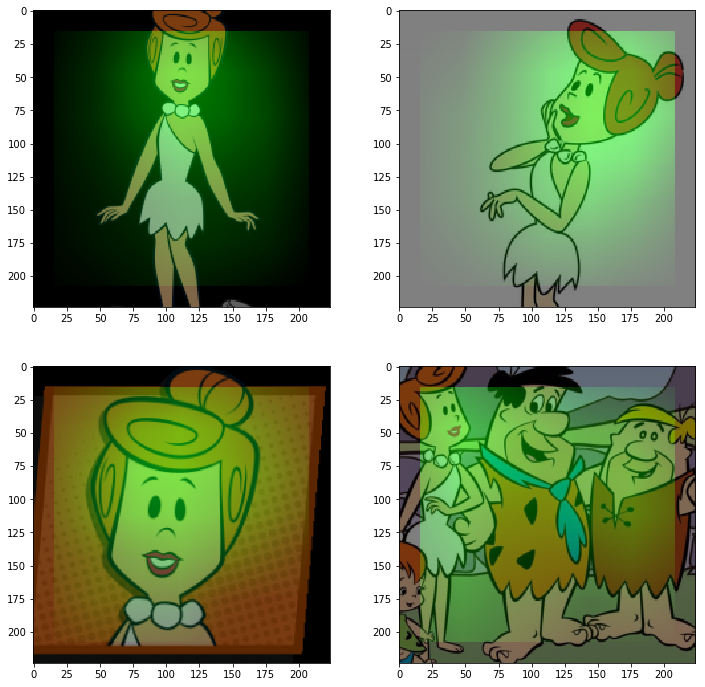

In [19]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.022168   0.296686   0.96875   



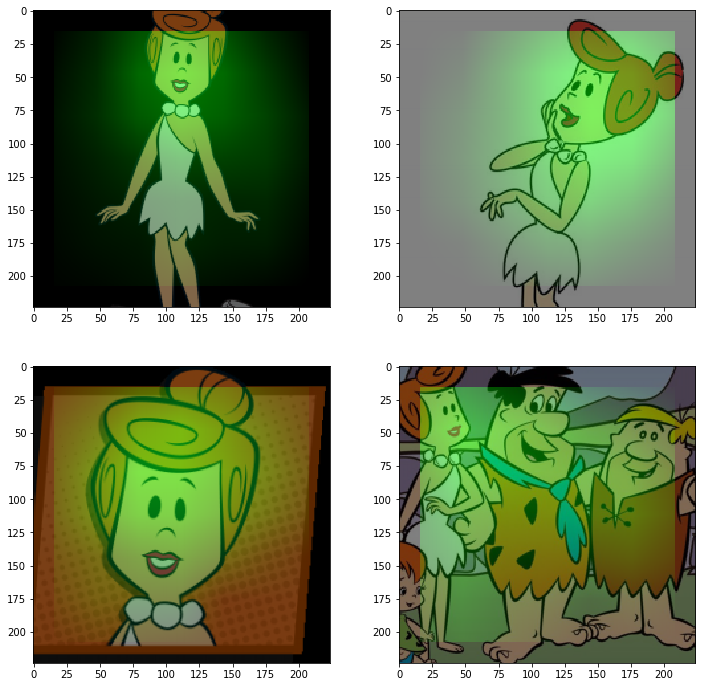

In [20]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)